In [1]:
import os
import pandas as pd
import h5py

%matplotlib inline

from IPython.display import display, HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
# Daysim data
trip = pd.read_csv(r'../../../outputs/daysim/_trip.tsv', sep='\t')
person = pd.read_csv(r'../../../outputs/daysim/_person.tsv', sep='\t')
hh = pd.read_csv(r'../../../outputs/daysim/_household.tsv', sep='\t')

In [3]:
pd.options.display.float_format = '{:0,.2f}'.format

In [4]:
# Weekdays in year
annual_factor = 300

# Soundcast Metrics
----

### Average Daily Miles Driven per Person

In [5]:
df = pd.read_excel(r'../../../outputs/network/network_summary_detailed.xlsx', sheetname='UC VMT')
tot_vmt = df.drop(['@lttrk','@mveh','@hveh','@bveh'], axis=1).sum().sum()
tot_pop = person['psexpfac'].sum()
x = tot_vmt/tot_pop
print '{:0,.1f}'.format(x)

19.9


### Hours of Congestion per Person per Year
For average Puget Sound resident:

In [6]:
net_sum = pd.read_excel(r'../../../outputs/network/network_summary_detailed.xlsx', sheetname='UC Delay')
veh_delay = net_sum.drop(['@lttrk','@mveh','@hveh','@bveh'], axis=1).sum().sum()
tot_pop = person['psexpfac'].sum()
x = (veh_delay/tot_pop)*annual_factor
print '{:0,.1f}'.format(x)

34.0


### Annual Hours of Delay by Average Truck
Average annual delay (hours) per truck trip in and through the region:

In [7]:
# Load truck trips
df = pd.read_csv(r'../../../outputs/network/trucks.csv')

# Truck delay
net_sum = pd.read_excel(r'../../../outputs/network/network_summary_detailed.xlsx', sheetname='UC Delay')

# Annual delay hours
daily_delay = net_sum[['@mveh','@hveh']].sum().sum()


# total truck trips
trips = df['prod'].sum()

# average annual delay hours per truck
x = (daily_delay*annual_factor)/trips
print'{:0,.1f}'.format(x)

67.6


*Medium trucks only:*

In [8]:
x = (net_sum['@mveh'].sum()*annual_factor)/df[df['Unnamed: 0'] == 'mt']['prod'].values[0]
print '{:0,.1f}'.format(x)

58.5


*Heavy trucks only:*

In [9]:
x = (net_sum['@hveh'].sum()*annual_factor)/df[df['Unnamed: 0'] == 'ht']['prod'].values[0]
print '{:0,.1f}'.format(x)

102.2


### % Population Walking or Biking for Transportation

In [10]:
trip_person = pd.merge(trip,person,on=['hhno','pno'], how='left')
bike_walk_trips = trip_person[trip_person['mode'].isin([1,2])]

df = bike_walk_trips.groupby(['hhno','pno']).count()
df = df.reset_index()
df = df[['hhno','pno']]
df['bike_walk'] = True

df = pd.merge(person,df,on=['hhno','pno'], how='left')
df['bike_walk'] = df['bike_walk'].fillna(False)

pd.options.display.float_format = '{:,.1%}'.format
df = pd.DataFrame(df.groupby('bike_walk').sum()['psexpfac']/df['psexpfac'].sum())
print '{:,.1%}'.format(df.loc[True]['psexpfac'])

27.8%


## Household and Jobs within 1/4 mile transit

In [11]:
# Network data
df = pd.read_excel(r'../../../outputs/network/network_summary_detailed.xlsx', sheetname='Transit Job Access')

**Households**

In [12]:
x = df.loc['hh_p']['quarter_mile_transit']
print '{:,.0f}'.format(x) + " households within 1/4 mile of transit"
x = (df.loc['hh_p']['quarter_mile_transit']*1.0)/df.loc['hh_p']['total']
print '{:,.1%}'.format(x) + " of total households"

702,604 households within 1/4 mile of transit
46.6% of total households


**Jobs**

In [13]:
x = df.loc['emptot_p']['quarter_mile_transit']
print '{:,.0f}'.format(x) + " jobs within 1/4 mile of transit"
x = (df.loc['emptot_p']['quarter_mile_transit']*1.0)/df.loc['emptot_p']['total']
print '{:,.1%}'.format(x) + " of total jobs"

1,366,266 jobs within 1/4 mile of transit
68.0% of total jobs


### Percent of Population within 1/2 mile of Frequent Transit
15 minute frequency during AM/PM peak

In [14]:
pd.options.display.float_format = '{:0,.2f}'.format
df = pd.read_csv(r'..\..\..\outputs\transit\freq_transit_access.csv')
hh = pd.read_csv(r'..\..\..\outputs\daysim\_household.tsv', sep='\t')
df = pd.merge(hh, df, left_on='hhparcel', right_on='PARCELID', how='left')
max_dist = 0.5

tot_within = df[df['dist_frequent'] <= max_dist]['hhsize'].sum()
tot_pop = df['hhsize'].sum()


In [15]:
print str('{:,.0f}'.format(tot_within)) + " people within 1/2 mile of frequent transit"
print str('{:,.1%}'.format(tot_within*1.0/tot_pop)) + " of regional population"

1,151,518 people within 1/2 mile of frequent transit
30.7% of regional population


### Highway Peak Period Travel Times
(Zone to Zone travel times)

In [2]:
# Load observed data (2013 currently)
od_obs = pd.read_csv(r'..\..\..\scripts\summarize\inputs\network_summary\od_travel_times.csv')

**AM Travel Times**

In [3]:
user_class = 'svtl1t'
max_internal_zone = 3700
zone_list = [532,2286,1552,1125,3108]

# Need zone terminal times to compare to observed
o_tt = pd.read_csv(r'..\..\..\inputs\IntraZonals\origin_tt.in',
                   sep=' ',header=4)


o_tt.index = o_tt.index.get_level_values(1)
o_tt['taz'] = o_tt.index
o_tt['terminal_time'] = o_tt['matrix=mo"prodtt"']
o_tt = pd.DataFrame(o_tt[['terminal_time','taz']])

results_dict = {}

for skim_name in ['7to8','10to14','17to18']:
    user_class_dict = {}
    for user_class in ['svtl2t','h3tl2t']:
        results = pd.DataFrame()
        h5_contents = h5py.File(r'..\..\..\inputs' + r'\\' + skim_name + '.h5')
        for zone in zone_list:
            df = pd.DataFrame()
            df[user_class] = h5_contents['Skims'][user_class][:][zone-1,:max_internal_zone]
            df['otaz'] = zone
            df['dtaz'] = df.index+1
            df['travel_time'] = df[user_class]/100 # skim data is stored in hundreds

            df = df[df['dtaz'].isin(zone_list)]

    #      Subtract the terminal times
            df = pd.merge(df,o_tt,left_on='dtaz',right_on='taz')
            # Subtract destination terminal time
            df['travel_time'] = df['travel_time']-df['terminal_time']
            # Subtract origin terminal time
            df['travel_time'] = df['travel_time']-(o_tt[o_tt['taz'] == zone]['terminal_time'].values[0])

            results = results.append(df)

        user_class_dict[user_class] = results
    results_dict[skim_name] = user_class_dict

In [4]:
df = results_dict['7to8']['svtl2t']
# df = results_dict['10to14']['svtl2t']
df = pd.merge(df,od_obs,on=['otaz','dtaz'])
df = df[['o_city','d_city','travel_time','optimistic','best_guess','pessimistic','time']]
df['corridor']=df['o_city']+'-'+df['d_city']
df = df[df['time'] == 'am']

df = df.rename(columns={'travel_time':'travel_time_model',
                   'optimistic':'observed_low',
                  'best_guess':'observed_mid',
                   'pessimistic':'observed_high'})
df.index = df.corridor
pd.options.display.float_format = '{:0,.0f}'.format
df = df.drop(['corridor','time'], axis=1)
df = df.rename(columns={'o_city':'From','d_city':'To','travel_time_model':'Model', 
                   'observed_low': 'Observed (Low)', 'observed_mid': 'Observed (Mid)', 'observed_high': 'Observed (High)'})
df.reset_index().drop('corridor', axis=1)

,From,To,Model,Observed (Low),Observed (Mid),Observed (High)
0,Seattle,Bellevue,22,17,22,29
1,Seattle,Everett,44,31,34,41
2,Seattle,Tacoma,46,32,35,41
3,Everett,Seattle,64,44,50,76
4,Everett,Bellevue,60,37,45,68
5,Everett,Tacoma,108,70,80,106
6,Bellevue,Seattle,26,19,26,41
7,Bellevue,Everett,40,30,33,37
8,Bellevue,Tacoma,59,37,40,48
9,Tacoma,Seattle,66,47,56,89


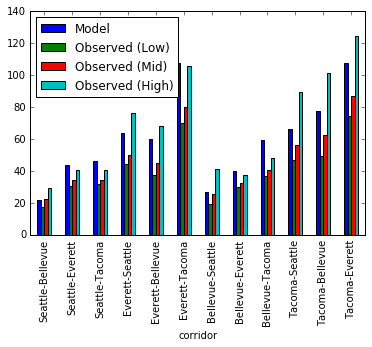

In [5]:
df.plot(kind='bar')

**PM Travel Times**

In [6]:
df = results_dict['17to18']['svtl2t']
# df = results_dict['10to14']['svtl2t']
df = pd.merge(df,od_obs,on=['otaz','dtaz'])
df = df[['o_city','d_city','travel_time','optimistic','best_guess','pessimistic','time']]
df['corridor']=df['o_city']+'-'+df['d_city']
df = df[df['time'] == 'pm']

df = df.rename(columns={'travel_time':'travel_time_model',
                   'optimistic':'observed_low',
                  'best_guess':'observed_mid',
                   'pessimistic':'observed_high'})
df.drop(['corridor','time'], axis=1)
df = df.rename(columns={'o_city':'From','d_city':'To','travel_time_model':'Model', 
                   'observed_low': 'Observed (Low)', 'observed_mid': 'Observed (Mid)', 'observed_high': 'Observed (High)'})
df.reset_index().drop(['corridor','index','time'], axis=1)

,From,To,Model,Observed (Low),Observed (Mid),Observed (High)
0,Seattle,Bellevue,26,16,22,31
1,Seattle,Everett,64,42,52,68
2,Seattle,Tacoma,66,50,59,76
3,Everett,Seattle,48,44,53,70
4,Everett,Bellevue,41,30,34,41
5,Everett,Tacoma,112,81,91,109
6,Bellevue,Seattle,24,24,34,51
7,Bellevue,Everett,60,38,49,64
8,Bellevue,Tacoma,81,61,74,98
9,Tacoma,Seattle,48,35,40,52


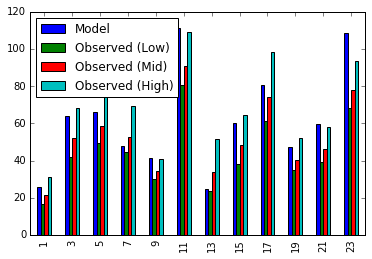

In [7]:
df.plot(kind='bar')

### Annual Travel Cost per Household 
Out of pocket costs (fuel, tolls, transit fares)

In [22]:
df = trip.groupby('hhno').sum()['travcost']
df = df.reset_index()
df = pd.merge(hh,df,on='hhno',how='left')
df['travcost'] = df['travcost'].fillna(0)
x = df['travcost'].mean()*annual_factor
print '${:0,.0f}'.format(x)

$3,325


In [23]:
max_income = 200000 # in 
income_bins = [i for i in xrange(0,max_income,10000)]
income_bins.append(1000000000)
income_labels = [str(i) for i in xrange(10000,max_income,10000)]
income_labels.append(str(max_income)+'+')
df['income'] = pd.cut(df['hhincome'],bins=income_bins,labels=income_labels)
df = pd.DataFrame(df.groupby('income').mean()['travcost'])
df['annual_cost'] = df['travcost']*annual_factor

Annual costs by income

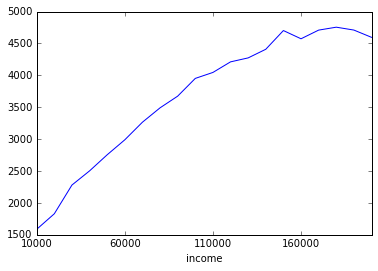

In [24]:
pd.options.display.float_format = '{:0,.2f}'.format
df['annual_cost'].plot()

## Transit Boardings

In [25]:
df = pd.read_excel(r'../../../outputs/network/network_summary_detailed.xlsx', sheetname='Transit Summaries')
tod_list = ['5to6','6to7','7to8','8to9','9to10','10to14','14to15','15to16','16to17','17to18','18to20']
df = df[[tod+'_board' for tod in tod_list]+['route_code']]
df = df.fillna(0)
df['line_total'] = df[[tod+'_board' for tod in tod_list]].sum(axis=1)

#Boardings by transit agency
agency_lookup = {
    '1': 'King County Metro',
    '2': 'Pierce Transit',
    '3': 'Community Transit',
    '4': 'Kitsap Transit',
    '5': 'Washington Ferries',
    '6': 'Sound Transit',
    '7': 'Everett Transit'
}
df['agency'] = df['route_code'].astype('str').iloc[0][0]
df['agency'] = df['agency'].map(agency_lookup)
df = pd.DataFrame(df.groupby('agency').sum()['line_total'])
df

,line_total
agency,
Kitsap Transit,"618,347.44"
